# Simulation and Simple Likelihood for scRNA-seq

Min Cheol Kim

In this exercise, I generate some data that (could) look like RNA seq in 1 dimension under some assumptions, and design a likelihood function that could recover (some) parameters.

### Imports

In [4]:
%matplotlib inline

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import itertools
import time

### Simulation

Let us simulate a possible procedure for generadting scRNA-seq data in 1 dimension (1 gene case).


1. The underlying distribution Z is mean $\mu$ with variance $\sigma^{2}$, $Z \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
$
2. Then, for each cell sampled from this distribution, we round to the nearest integer and sample a binomial random variable X distributed as $X \sim B(Z, p)$ where the sampled $Z$ serves as the number of trials and $p$ serves as the dropout rate of an individual transcript in a cell.

For this simulation, we use:
- $N$ = 100,000
- $\mu$ = 10
- $\sigma$ = 2
- $p$ = 0.1


In [28]:
# Parameters
num_cells = 10000
p = 0.1
mu = 10
sigma = 2

In [21]:
ground_truth_counts = np.random.normal(mu, sigma, size=num_cells)

In [22]:
observed = np.random.binomial(n=np.round(ground_truth_counts).astype(np.int64), p=p)

In [23]:
best_mu, best_sigma = stats.norm.fit(sim_truth)
print('Best possible estimate of mu:', best_mu)
print('Best possible estimate of sigma:', best_sigma)

Best possible estimate of mu: 9.992905225409059
Best possible estimate of sigma: 1.9900160506408178


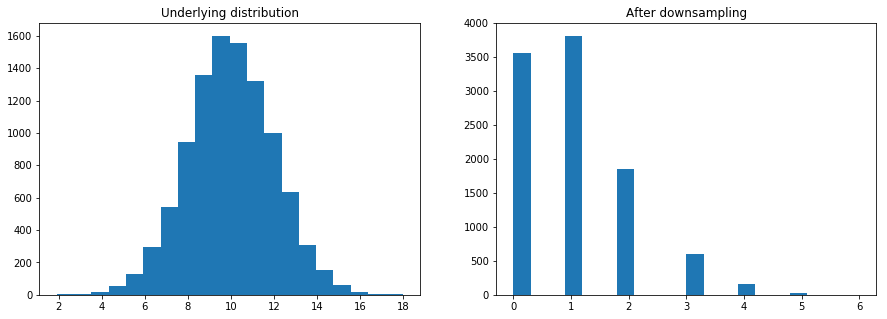

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1);
plt.title('Underlying distribution')
plt.hist(sim_truth, bins=20);
plt.subplot(1, 2, 2);
plt.title('After downsampling')
plt.hist(observed, bins=20);

### 1D Likelihood Function

I define the log liklihood given data $x_1, x_2, x_3, x_4, ... , x_N$as follows:

$$ LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) = \sum_{i=1}^{N}\log\bigg(\sum_{z=0}^{\infty} \bigg[{z\choose{x_i}}p^{x_i}(1-p)^{z-x_i}\bigg] \bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\bigg(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\bigg)\bigg]\bigg) $$

In [29]:
def likelihood(p, mu, sigma, val):
    
    lh = 0
    for n in range(50): #50 is a heuristic
        lh += stats.binom.pmf(val, n, p) * stats.norm.pdf(n, mu, sigma)
    return np.log(lh).sum()

### Brute force grid search

This likelihood function is obviously not concave (so maximizing is not a convex optimization problem), but it may be possible to design some optimization procedure for finding good parameters, given some reasonable constraints on $p$ the dropout rate and $\mu$ the mean estimated from either pseudobulks for bulk RNA-seq experiments.

The optimization problem we'd like to eventually solve is:

\begin{equation*}
\begin{aligned}
& \underset{p,\ \mu,\ \sigma}{\text{minimize}}
& & LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) \\
& \text{subject to}
& & 0.05 < p < 0.15, \\
&&& \mu_{min}\ <\ \mu\ <\ \mu_{max}
\end{aligned}
\end{equation*}

For now, I just sanity-check the likelihood with some brute force parameter search, and confirm that multiple arrangements of the parameters yield optimal likelihood (hence nonconvex) but the problem may be tractable if we contrain $\mu$ and $p$ enough.

In [31]:
p_cand = np.arange(0.02, 0.2, 0.02)
mu_cand = np.arange(5, 15, 1)
sigma_cand = np.arange(.0, 3.0, 0.2)

In [237]:
results = []
for p, mu, sigma in itertools.product(p_cand, mu_cand, sigma_cand):
    results.append((p, mu, sigma, likelihood(p, mu, sigma, binom_observed)))
results = pd.DataFrame(results, columns=['p', 'mu', 'sigma', 'log_likelihood'])\
    .sort_values('log_likelihood', ascending=False)

### Results

If we had an accurate mean, our estimates are pretty good. I think it may be worth it to look into an actual optimization procedure, and test feasibility in multiple dimensions (estimation of the covariance matrix).

In [248]:
print('Top parameters if we had an accurate mean:')
results.query('mu == 10').head(5)

If we had an accurate mean:


,p,mu,sigma,log_likelihood
455,0.1,10,2.0,-12582.491198
454,0.1,10,1.8,-12582.598059
456,0.1,10,2.2,-12582.733354
453,0.1,10,1.6,-12582.963630
457,0.1,10,2.4,-12583.446180


In [252]:
print('Top parameters if we didn\'t have an accurate mean:')
results.head(5)

Top parameters if we didn't have an accurate mean:


,p,mu,sigma,log_likelihood
373,0.08,12,1.6,-12566.537816
374,0.08,12,1.8,-12566.568674
372,0.08,12,1.4,-12566.610606
535,0.12,8,2.0,-12566.625604
375,0.08,12,2.0,-12566.741074
